In [1]:
import re

EVAL = [
    {"query": "EGFR inhibitors",                "relevant_target": r"\bEGFR\b"},
    {"query": "HER2 compounds with low IC50",   "relevant_target": r"\bHER2\b|\bERBB2\b"},
    {"query": "CYP2D6 inhibition evidence",     "relevant_target": r"\bCYP2D6\b"},
    {"query": "hERG blockers",                  "relevant_target": r"\bKCNH2\b|\bhERG\b"},
]

def is_relevant(row, pattern: str) -> bool:
    tgt = (row.get("target") or "")
    return bool(re.search(pattern, str(tgt), flags=re.I))


In [5]:
import faiss, pickle
from pathlib import Path

processed_dir = Path("../data/processed")

# Reload FAISS index
index = faiss.read_index(str(processed_dir / "evidence_faiss.index"))

# Reload metadata mapping
with open(processed_dir / "id_to_row.pkl", "rb") as f:
    id_to_row = pickle.load(f)

print("✅ Index and metadata loaded")
print("Index size:", index.ntotal)


✅ Index and metadata loaded
Index size: 5000


In [6]:
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer

# reload the embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

# assume index + id_to_row already loaded earlier:
# index = faiss.read_index(str(processed_dir / "evidence_faiss.index"))
# with open(processed_dir / "id_to_row.pkl", "rb") as f: id_to_row = pickle.load(f)

def retrieve(query, k=5):
    """Search FAISS index with query and return top-k evidence rows."""
    q_emb = model.encode([query], convert_to_numpy=True).astype("float32")
    faiss.normalize_L2(q_emb)
    scores, idxs = index.search(q_emb, k)
    results = []
    for score, i in zip(scores[0], idxs[0]):
        row = id_to_row[i]
        results.append({**row, "score": float(score)})
    return results


In [7]:
rows = []
all_hits = {}
for item in EVAL:
    metrics, hits = evaluate_retrieval(item["query"], item["relevant_target"], k=10)
    rows.append(metrics)
    all_hits[item["query"]] = hits

import pandas as pd
df_eval = pd.DataFrame(rows)
display(df_eval)


,query,k,latency_ms,precision_at_k,recall_at_k,ndcg_at_k,num_hits,num_relevant_in_hits
0,EGFR inhibitors,10,74.65,0.0,0.0,0.0,10,0
1,HER2 compounds with low IC50,10,282.41,0.0,0.0,0.0,10,0
2,CYP2D6 inhibition evidence,10,8.96,1.0,1.0,1.0,10,10
3,hERG blockers,10,8.39,0.0,0.0,0.0,10,0


In [8]:
from transformers import pipeline
import time

# Use FLAN-T5 with seq2seq pipeline
summarizer = pipeline("text2text-generation", model="google/flan-t5-base", device_map="auto")

def to_citation_lines(hits):
    lines = []
    for e in hits:
        ligand = e.get("ligand") or e.get("smiles")
        lines.append(f"{ligand} | Target={e['target']} | {e['activity_type']}={e['value']} | p={e['pValue']}")
    return "\n".join(lines)

def summarize_with_citations(query, hits, max_new_tokens=256):
    context = to_citation_lines(hits)
    prompt = (
        "You are a scientific assistant. Summarize the evidence below in 3–5 bullets. "
        "Each bullet MUST include a citation with ligand/target/value in parentheses.\n\n"
        f"Evidence:\n{context}\n\nSummary:"
    )
    t0 = time.perf_counter()
    out = summarizer(prompt, max_new_tokens=max_new_tokens, truncation=True)[0]["generated_text"]
    t1 = time.perf_counter()
    return out, round((t1 - t0) * 1000, 2)

def citations_ok(text):
    # simple heuristic: at least 3 bullets and at least 3 parentheses pairs
    bullets = [ln for ln in text.splitlines() if ln.strip().startswith(("-", "•", "*"))]
    return (len(bullets) >= 3) and (text.count("(") >= 3 and text.count(")") >= 3)


Device set to use mps


In [9]:
import pandas as pd
from pathlib import Path

out_rows = []
for item in EVAL:
    # retrieval
    m, hits = evaluate_retrieval(item["query"], item["relevant_target"], k=10)
    
    # summarization
    summary, gen_ms = summarize_with_citations(item["query"], hits[:5])  # summarize top-5
    m.update({
        "gen_latency_ms": gen_ms,
        "citations_ok": citations_ok(summary),
        "summary_preview": summary[:300].replace("\n", " ")
    })
    out_rows.append(m)

df_eval = pd.DataFrame(out_rows)
display(df_eval)

# Save to CSV log for RAGOps monitoring
log_path = Path("../data/processed/ragops_eval.csv")
mode = "a" if log_path.exists() else "w"
df_eval.to_csv(log_path, index=False, mode=mode, header=(mode=="w"))
print(f"✅ Logged eval to {log_path}")


,query,k,latency_ms,precision_at_k,recall_at_k,ndcg_at_k,num_hits,num_relevant_in_hits,gen_latency_ms,citations_ok,summary_preview
0,EGFR inhibitors,10,223.90,0.0,0.0,0.0,10,0,17271.60,False,CCC(C)[C@@H] (NC(=O)[C@@H]1CCCN1C(=O)[C@@H](N)...
1,HER2 compounds with low IC50,10,16.02,0.0,0.0,0.0,10,0,7943.82,False,Cn1c(I)c2cc(C(O)=O)c(O)cc12)-c1ccc(NC(=O)C(=O)...
2,CYP2D6 inhibition evidence,10,28.92,1.0,1.0,1.0,10,10,8362.60,False,CC(CCC(O)O)(c1cc(Br)c(O)c(Br)c1)c1cc(Br)c(O)c(...
3,hERG blockers,10,20.29,0.0,0.0,0.0,10,0,872.48,False,Identify the target of the c2C(OC)[O-] ligand.


✅ Logged eval to ../data/processed/ragops_eval.csv


In [10]:
import datetime
m["run_date"] = datetime.datetime.now().isoformat()
m["embedding_model"] = "all-MiniLM-L6-v2"


In [12]:
from sklearn.metrics import ndcg_score

def evaluate_retrieval(query, relevant_regex, k=10):
    t0 = time.perf_counter()
    hits = retrieve(query, k=k)
    t1 = time.perf_counter()
    y_true = [1 if is_relevant(h, relevant_regex) else 0 for h in hits]
    y_pred = [h["score"] for h in hits]
    hit_count = sum(y_true)
    precision_at_k = hit_count / max(1, len(hits))
    hit_rate = 1.0 if hit_count > 0 else 0.0
    ndcg = ndcg_score([y_true], [y_pred]) if any(y_true) else 0.0
    return {
        "query": query,
        "k": k,
        "latency_ms": round((t1 - t0) * 1000, 2),
        "precision_at_k": round(precision_at_k, 3),
        "hit_rate_at_k": round(hit_rate, 3),
        "ndcg_at_k": round(float(ndcg), 3),
        "num_hits": len(hits),
        "num_relevant_in_hits": int(hit_count)
    }, hits


In [21]:
rows = []
for item in EVAL:
    m, hits = evaluate_retrieval(item["query"], item["relevant_target"], k=10)
    summary, gen_ms = summarize_with_citations(item["query"], hits[:5])
    m.update({
        "gen_latency_ms": gen_ms,
        "citations_ok": citations_ok(summary),
        "summary_preview": summary[:300].replace("\n", " ")
    })
    rows.append(m)

import pandas as pd
df_eval = pd.DataFrame(rows)
display(df_eval)


,query,k,latency_ms,precision_at_k,hit_rate_at_k,ndcg_at_k,num_hits,num_relevant_in_hits,gen_latency_ms,citations_ok,summary_preview
0,EGFR inhibitors,10,3828.07,0.0,0.0,0.0,10,0,12995.49,False,CCC(C)[C@@H] (NC(=O)[C@@H]1CCCN1C(=O)[C@@H](N)...
1,HER2 compounds with low IC50,10,44.09,0.0,0.0,0.0,10,0,4776.50,False,Cn1c(I)c2cc(C(O)=O)c(O)cc12)-c1ccc(NC(=O)C(=O)...
2,CYP2D6 inhibition evidence,10,10.30,1.0,1.0,1.0,10,10,4675.79,False,CC(CCC(O)O)(c1cc(Br)c(O)c(Br)c1)c1cc(Br)c(O)c(...
3,hERG blockers,10,8.25,0.0,0.0,0.0,10,0,509.07,False,Identify the target of the c2C(OC)[O-] ligand.


In [22]:
m["gen_model"] = "flan-t5-base"
m["k"] = 10


In [20]:
print(df_eval.columns.tolist())


['query', 'k', 'latency_ms', 'precision_at_k', 'recall_at_k', 'ndcg_at_k', 'num_hits', 'num_relevant_in_hits', 'gen_latency_ms', 'citations_ok', 'summary_preview']


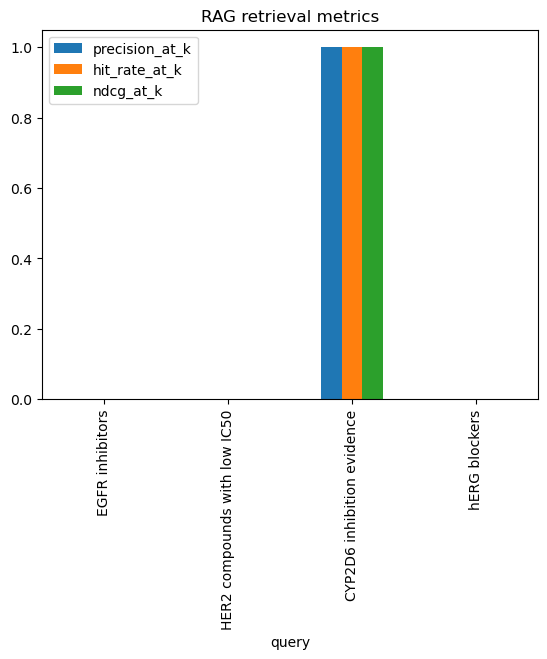

In [23]:
import matplotlib.pyplot as plt
df_eval.set_index("query")[["precision_at_k","hit_rate_at_k","ndcg_at_k"]].plot(kind="bar")
plt.title("RAG retrieval metrics"); plt.show()
